<a href="https://colab.research.google.com/github/evan-placenis/SkimLit-NLP/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Data
Replicating PubMed 200k RCT paper

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 8.02 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
#check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [ ]:
#function to read the lines of a txt file
def get_lines(filename):
  """
  Reads filename and returns the lines of text as a list

  Args:
    filename: a string containing the target filepath

  Retruns:
    A list of strings with one string per line from the target filename

  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]


['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data

  Takes in filename, reads it contents and sorts through each line,
  extracting the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) #get all lines from filename
  abstract_lines = "" #create an empty abstract
  abstract_samples = [] #creat an empty list of abstracts

  for line in input_lines:
    if line.startswith("###"): #new abstract is starting
      abstract_id = line
      abstract_lines = ""
    elif line.isspace(): #check if line is a new line
      abstract_line_split = abstract_lines.splitlines()

      #iterate through each line and count them
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #creat an empty dictionary for each line
        target_text_split = abstract_line.split("\t")
        line_data["line_number"] = abstract_line_number #what line number does this occur at
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["total_lines"] = len(abstract_line_split) - 1 #how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data)

    else: #if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples



In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 577 ms, sys: 95.3 ms, total: 673 ms
Wall time: 817 ms


In [ ]:
#check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
val_df.head(14)

,line_number,target,text,total_lines
0,0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,9
1,1,BACKGROUND,it is not clear whether these patients would b...,9
2,2,OBJECTIVE,we sought to determine whether a @-month cours...,9
3,3,METHODS,asthmatic patients who were ige sensitized to ...,9
4,4,METHODS,primary outcomes were improvement in quality o...,9
5,5,RESULTS,sixty-five patients were randomized .,9
6,6,RESULTS,fifty-nine patients started treatment ( @ rece...,9
7,7,RESULTS,fifty-six patients took the full @ months of m...,9
8,8,RESULTS,"between the voriconazole and placebo groups , ...",9
9,9,CONCLUSIONS,we were unable to show a beneficial effect of ...,9


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

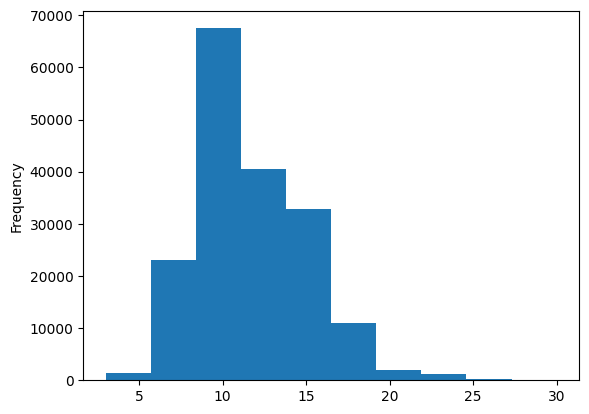

In [ ]:
train_df.total_lines.plot.hist()

Get list of sentences

In [ ]:
#convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

print(len(train_sentences), len(val_sentences), len(test_sentences))

180040 30212 30135


##Make numeric labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
#exctract labels("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
#get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

##Model 0: TF-IDF Multinomial Naive Bays Classifier (baseline)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

#fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)



Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
#Evaluate on val data
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [ ]:
#make predictions useing our baseline
baseline_preds = model_0.predict(val_sentences)

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-18 16:39:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-18 16:39:36 (92.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Preparing text for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
#how long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

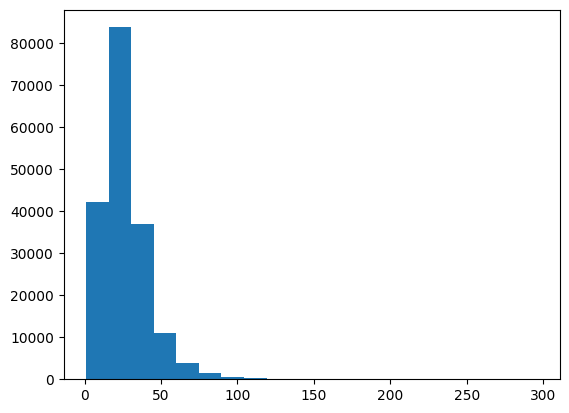

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20)

In [ ]:
#how long of a setnence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

Text Vectorization layer - maps words to numbers

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_tokens = 68000
text_vectorizer = TextVectorization(max_tokens = max_tokens, #number of words in vocabulary
                                    output_sequence_length = output_seq_len) #desired ouput length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text: \n {target_sentence}")
print(f"\n:Length of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text: 
 this was a randomized controlled trial of single dose placebo , @ or @ mg dronabinol in @ chronic noncancer pain patients taking opioids and not using marijuana .

:Length of text: 162

Vectorized text: [[   23    10     8    29   106    32     4   312   131    48    16    68
  23314     5   244 10648    65    12  1140  2665     3    31    59  6279
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")

Number of words in vocab: 64841


In [ ]:
#get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

Create custom text embedding

In [ ]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), #length of vocabulary
                               output_dim = 128, #Note: different embedding sizes resutls in drastically different numbers of paramaters to train
                               mask_zero = True, #use masking to handle variable sequence lengths (save space)
                               name = "token_embedding")

In [ ]:
print(f"Sentence before vectorization: \n {target_sentence} \n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding): \n {vectorized_sentence}\n")
embedding_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedding_sentence} \n")
print(f"Embedded sentence shape: {embedding_sentence.shape}")

Sentence before vectorization: 
 this was a randomized controlled trial of single dose placebo , @ or @ mg dronabinol in @ chronic noncancer pain patients taking opioids and not using marijuana . 

Sentence after vectorization (before embedding): 
 [[   23    10     8    29   106    32     4   312   131    48    16    68
  23314     5   244 10648    65    12  1140  2665     3    31    59  6279
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.03980789  0.03120961  0.03864026 ...  0.0428991   0.02234859
   -0.03554151]
  [-0.04130007  0.00968252 -0.04549482 ...  0.01104411 -0.02936344
   -0.00293436]
  [-0.01271928 -0.01306111 -0.00085837 ...  0.02609414 -0.03676575
   -0.03172225]
  ...
  [ 0.04169654  0.01611687 -0.01502978 ... -0.01736418 -0.02152989
   -0.02841531]
  [ 0.04169654  0.01611687 -0.01502978 ... 

Creating datasets to make data load as fast as possible

In [ ]:
#Turn data into tensofrlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
#Take the TensorSlice Dataset's and turn them into prefentech datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

##Model 1: Conv1D with token embeddings

In [ ]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding = "same", activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x) #softmax because we are dealing with multiclass classification
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
#history_model_1 = model_1.fit(train_dataset,
 #                             steps_per_epoch = int(0.1*len(train_dataset)),
#                              epochs = 3,
 #                             validation_data = valid_dataset,
 #                             validation_steps = int(0.1*len(valid_dataset)))

In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 11s 4ms/step - loss: 1.6098 - accuracy: 0.1170


[1.6098496913909912, 0.1169733852148056]

In [ ]:
#make predications
model_1_pred_probs = model_1.predict(valid_dataset)
#convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
#calculate model 1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)

model_1_results

945/945 [==============================] - 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 11.69733880577254,
 'precision': 0.5018048757208107,
 'recall': 0.1169733880577254,
 'f1': 0.03064982381259074}

##Model 2: Feature extraction with pretrained token embeddings

In [ ]:
#Download pretrained Tensforlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")
random_train_sentence = random.choice(train_sentences)
print(f"Ranomd sentence :\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding :\n {use_embedded_sentence}")


Ranomd sentence :
 after baseline assessment participants will be allocated to one of two treatment conditions ( allocation ratio of @:@ ) using a stratified ( per site , per care pathway ) , blocked randomization procedure .
Sentence after embedding :
 [[-5.01390658e-02 -2.31919568e-02 -4.28300388e-02 -1.86396576e-02
  -3.21217291e-02 -5.97393513e-02 -2.63502635e-02 -3.61648351e-02
  -2.82862186e-02  6.90217093e-02  2.74518039e-02  5.54047711e-02
  -1.48669546e-02  2.51050536e-02 -5.81050515e-02  1.83579861e-03
  -5.20236827e-02  5.76221608e-02 -6.64137155e-02 -1.25540271e-02
   1.58822369e-02  1.68563481e-02 -4.93202917e-02 -5.52094318e-02
   7.23328367e-02  5.40435873e-03 -4.73001748e-02  5.85650951e-02
   2.44740248e-02 -1.12543013e-02 -1.60526484e-02  7.65433833e-02
  -8.79011568e-05  1.07280677e-02  1.87415592e-02 -9.06524714e-03
   5.12476638e-02 -1.08599821e-02 -6.62312359e-02 -2.71902550e-02
  -3.55733633e-02 -2.26473901e-02 -4.35041003e-02 -5.94848134e-02
   6.50460552e-03  7

In [ ]:
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embeddings = tf_hub_embedding_layer(inputs)
x= layers.Dense(128, activation = "relu")(pretrained_embeddings)
outputs = layers.Dense(5, activation = "softmax")(x) #softmax because we are dealing with multiclass classification
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_USE_feature_extractor")

model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 21s 23ms/step - loss: 0.9170 - accuracy: 0.6513 - val_loss: 0.7977 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7688 - accuracy: 0.7015 - val_loss: 0.7546 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 14s 25ms/step - loss: 0.7525 - accuracy: 0.7119 - val_loss: 0.7384 - val_accuracy: 0.7131


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.7416 - accuracy: 0.7139


[0.7416368722915649, 0.7138554453849792]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model_2_preds)

945/945 [==============================] - 10s 10ms/step


##Model 3: Conv1D with character embeddings

In [ ]:
#make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

split_chars(random_train_sentence)

'a f t e r   b a s e l i n e   a s s e s s m e n t   p a r t i c i p a n t s   w i l l   b e   a l l o c a t e d   t o   o n e   o f   t w o   t r e a t m e n t   c o n d i t i o n s   (   a l l o c a t i o n   r a t i o   o f   @ : @   )   u s i n g   a   s t r a t i f i e d   (   p e r   s i t e   ,   p e r   c a r e   p a t h w a y   )   ,   b l o c k e d   r a n d o m i z a t i o n   p r o c e d u r e   .'

In [ ]:
#split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
#whats the average character lenght
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

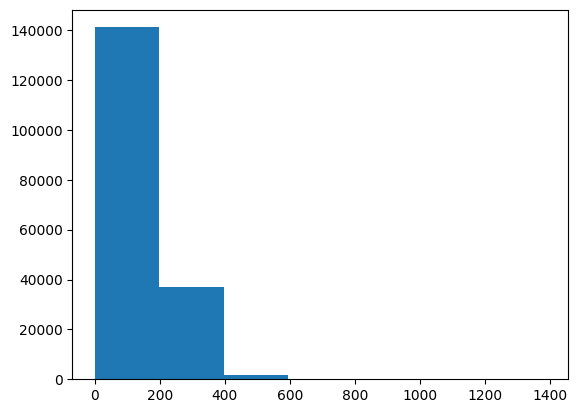

In [ ]:
#check the distribution of our sequences at the char level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)


In [ ]:
#Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))

In [ ]:
#get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 #add two for space and unknown character
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = "lower_and_strip_punctuation",
                                    name = "char_vectorizer")

In [ ]:
#Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

#check the character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text :\n {random_train_chars}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\n Vectorized chars:\n {vectorized_chars}")

Charified text :
 a l l   s u r g e r i e s   w e r e   p e r f o r m e d   b y   o n e   s u r g e o n   u s i n g   a   p o s t e r i o r - s t a b i l i z e d   c e m e n t e d   p r o s t h e s i s   .

 Vectorized chars:
 [[ 5 12 12  9 16  8 18  2  8  4  2  9 20  2  8  2 14  2  8 17  7  8 15  2
  10 22 19  7  6  2  9 16  8 18  2  7  6 16  9  4  6 18  5 14  7  9  3  2
   8  4  7  8  9  3  5 22  4 12  4 25  2 10 11  2 15  2  6  3  2 10 14  8
   7  9  3 13  2  9  4  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  

Create character level embedding

In [ ]:
char_embed = layers.Embedding(input_dim = len(char_vocab),# number of different characters,
                              output_dim = 25, #from paper
                              mask_zero = True,
                              name = "char_embed")

In [ ]:
#test out character embedding layer
print(f"Charified text : \n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embeded chars. \n {char_embed_example}")
print(f"Embeded chars shape {char_embed_example.shape}")

Charified text : 
 a l l   s u r g e r i e s   w e r e   p e r f o r m e d   b y   o n e   s u r g e o n   u s i n g   a   p o s t e r i o r - s t a b i l i z e d   c e m e n t e d   p r o s t h e s i s   .

Embeded chars. 
 [[[-0.02607247 -0.00154784 -0.01016096 ... -0.02905438  0.01494947
    0.04411072]
  [ 0.04957154 -0.04912692 -0.04092882 ... -0.04808741 -0.00207319
   -0.04314905]
  [ 0.04957154 -0.04912692 -0.04092882 ... -0.04808741 -0.00207319
   -0.04314905]
  ...
  [ 0.00736778 -0.00338004  0.00581149 ... -0.03236697  0.00565975
   -0.0241233 ]
  [ 0.00736778 -0.00338004  0.00581149 ... -0.03236697  0.00565975
   -0.0241233 ]
  [ 0.00736778 -0.00338004  0.00581149 ... -0.03236697  0.00565975
   -0.0241233 ]]]
Embeded chars shape (1, 290, 25)


In [ ]:
#make conv1D on chars only
inputs = layers.Input(shape=(1,), dtype = "string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = "model_3_conv1d_char_embeddings")

#compile
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
#creat char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 14ms/step - loss: 1.4568 - accuracy: 0.3529 - val_loss: 1.3986 - val_accuracy: 0.4076
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 1.3598 - accuracy: 0.4275 - val_loss: 1.3300 - val_accuracy: 0.4491
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 1.3242 - accuracy: 0.4522 - val_loss: 1.3172 - val_accuracy: 0.4425


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

945/945 [==============================] - 3s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.541903879253276,
 'precision': 0.3781936759725906,
 'recall': 0.44541903879253275,
 'f1': 0.38878307862098455}

##Model 4: Combine character and token embeddings - hybrid embedding layer

In [ ]:
#token inputs/model - functional API to combine multiple different steps

#Token layer
token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_input") #shape is empty array because thats what the embedding layer wants
token_embeddings = tf_hub_embedding_layer(token_inputs) #pretrained embedding layer
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

#character layer
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

# concatenate token and char inputs (create hybrid embedding)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output, char_model.output])

#build a series of ouput layers - adding in Dropout which removes x amount of weights to prevent overfitting
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout)

#construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

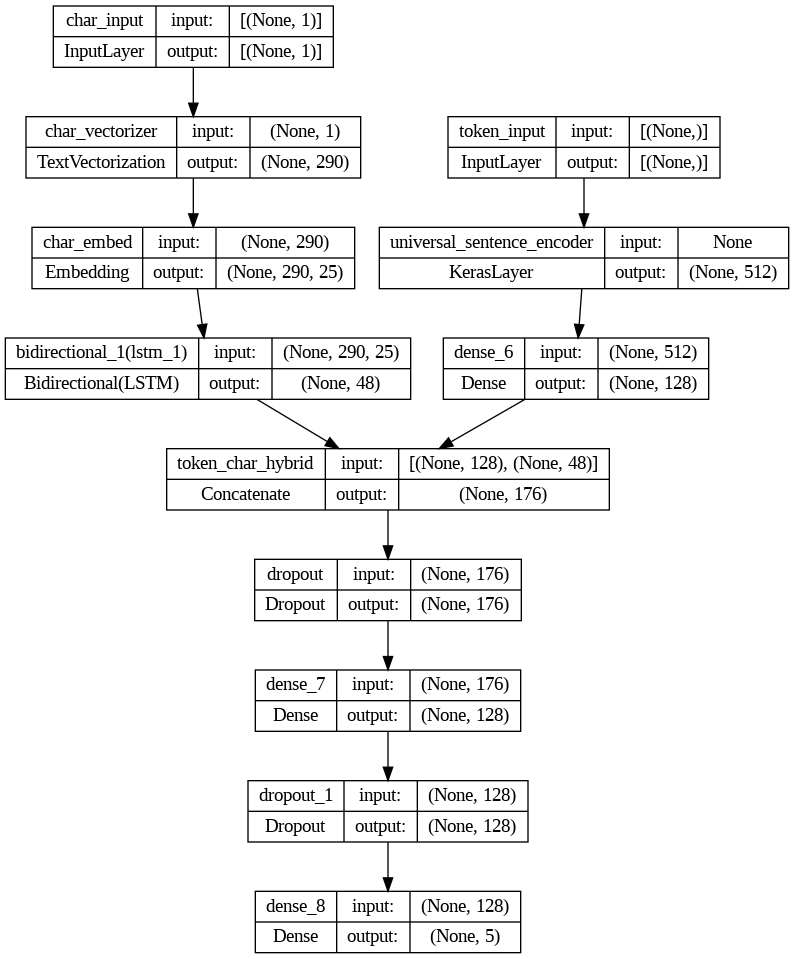

In [ ]:
#plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [ ]:
#compile
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
#create dataset pipline

#combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #make data (has to be same order as the model)
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))#combine data and labels

#prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
#Repeat for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) #make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) #make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))#combine data and
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset,val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_4.fit(train_char_token_dataset,
            steps_per_epoch = int(0.1*len(train_char_token_dataset)),
            epochs = 3,
            validation_data =val_char_token_dataset,
            validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 44s 58ms/step - loss: 0.9883 - accuracy: 0.6046 - val_loss: 0.7843 - val_accuracy: 0.7011
Epoch 2/3
562/562 [==============================] - 27s 49ms/step - loss: 0.8080 - accuracy: 0.6863 - val_loss: 0.7187 - val_accuracy: 0.7237
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7783 - accuracy: 0.7047 - val_loss: 0.6974 - val_accuracy: 0.7324


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 34s 36ms/step - loss: 0.7002 - accuracy: 0.7331


[0.700221836566925, 0.7331193089485168]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)

945/945 [==============================] - 22s 19ms/step


In [ ]:
model_4_results

{'accuracy': 73.3119290348206,
 'precision': 0.7331603641839873,
 'recall': 0.733119290348206,
 'f1': 0.7304656025189399}

##Model 4: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
#create positional embeddings
train_df["line_number"].value_counts() #how many lines are there per # of lines

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

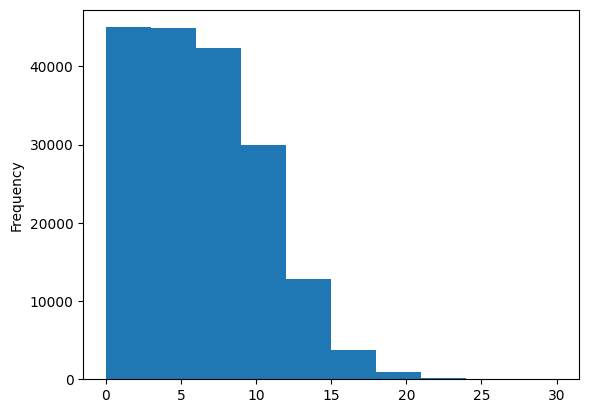

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
#use tensorflow to create one-hot-encoded tensors of our 'line_number"  column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth= 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth= 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth= 15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

<Axes: ylabel='Frequency'>

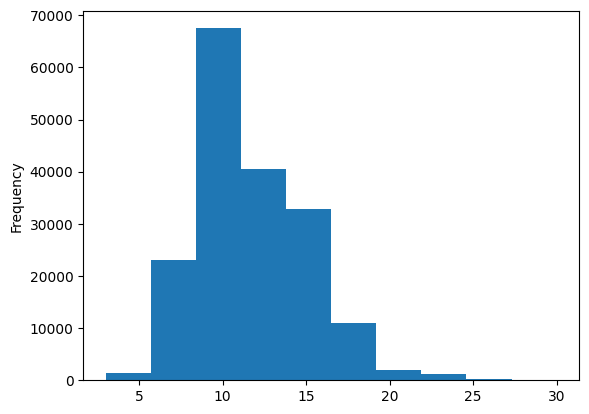

In [ ]:
#same steps for total lines feature
train_df.total_lines.plot.hist()

In [ ]:
#use tensorflow to create one-hot-encoded tensors of our 'total_lines"  column
train_total_numbers_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth= 20)
val_total_numbers_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth= 20)
test_total_numbers_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth= 20)
train_total_numbers_one_hot[:20], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

Building the tribrid embedding model

In [ ]:
#Token
token_inputs = layers.Input(shape = [], dtype = "string", name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

#char
char_inputs = layers.Input(shape=(1,), dtype = "string", name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

#line numbers
line_number_inputs = layers.Input(shape=(15,), dtype = tf.float32, name = "line_number_inputs")
x = layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs, outputs = x)

#total lines
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32, name = "total_lines_inputs")
y = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs, outputs = y)

#combine token and char embeddings into hybrid
combined_embeddings = layers.Concatenate(name = "char_token_hybrid_embedding")([token_model.output, char_model.output])

#dropout layer
z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

#combine positional embedding with combined token and char embedding
tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embedding")([line_number_model.output,
                                                                                   total_lines_model.output,
                                                                                   z])
#create output layer
output_layer = layers.Dense(5, activation = "softmax", name = "output_layer")(tribrid_embeddings)

#put together model with all kinds of inputs
model_5  = tf.keras.Model(inputs = [line_number_model.input, #order matters here
                                    total_lines_model.input,
                                    token_model.input,
                                    char_model.input],
                          outputs = output_layer,
                          name = "model_5_tribrid_embedding_model")


In [ ]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

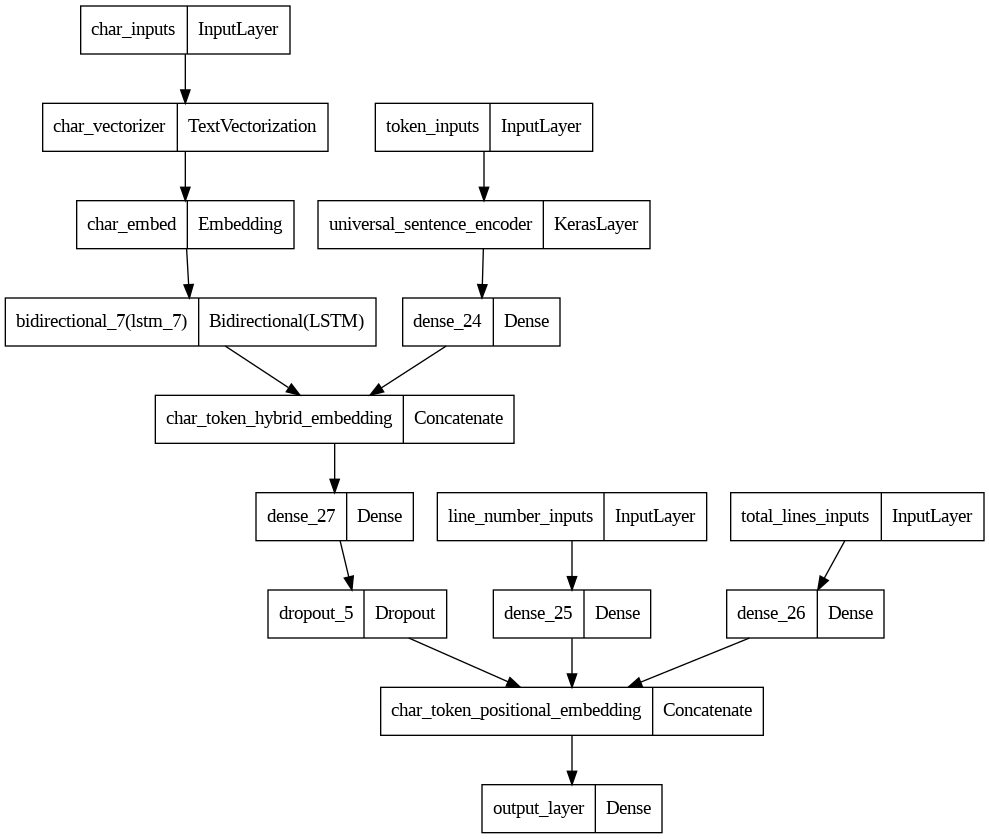

In [ ]:
from keras.utils import plot_model
plot_model(model_5)

In [ ]:
#compile token, char, and positonal embeding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), #helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

Create tribrid embedding datasets

In [ ]:
#training dataset
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_numbers_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_numbers_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#check input shapes
train_char_token_pos_dataset,val_char_token_pos_dataset,

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 59s 85ms/step - loss: 1.1001 - accuracy: 0.7184 - val_loss: 0.9833 - val_accuracy: 0.8049
Epoch 2/3
562/562 [==============================] - 44s 78ms/step - loss: 0.9682 - accuracy: 0.8127 - val_loss: 0.9505 - val_accuracy: 0.8281
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9488 - accuracy: 0.8258 - val_loss: 0.9391 - val_accuracy: 0.8275


In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose = 1)
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)

945/945 [==============================] - 22s 20ms/step


In [ ]:
model_5_results #10% better than model 4 with no positional embeddings

{'accuracy': 83.19210909572355,
 'precision': 0.8305891066588557,
 'recall': 0.8319210909572355,
 'f1': 0.8310446662316009}

## Compare Model Results

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding" : model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "modle_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,11.697339,0.501805,0.116973,0.030650
model_2_pretrained_token_embedding,71.385542,0.714454,0.713855,0.711112
model_3_custom_char_embedding,44.541904,0.378194,0.445419,0.388783
model_4_hybrid_char_token_embedding,73.311929,0.733160,0.733119,0.730466
modle_5_pos_char_token_embedding,83.192109,0.830589,0.831921,0.831045


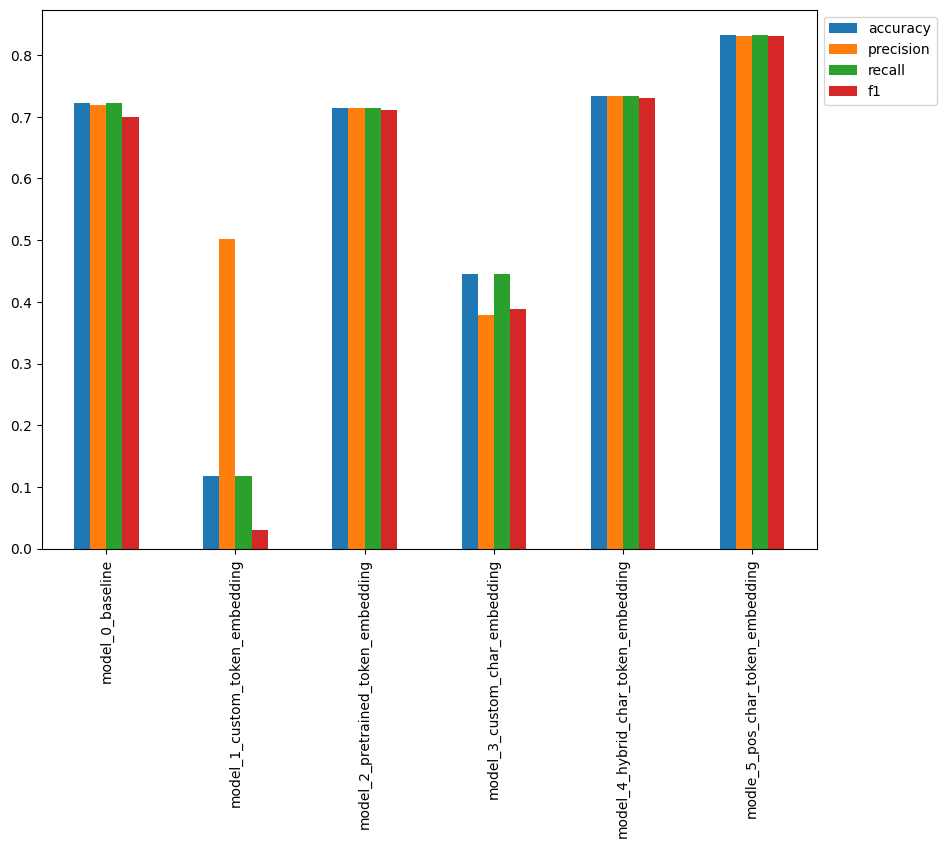

In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize = (10,7)).legend(bbox_to_anchor = (1.0,1.0))

<Axes: >

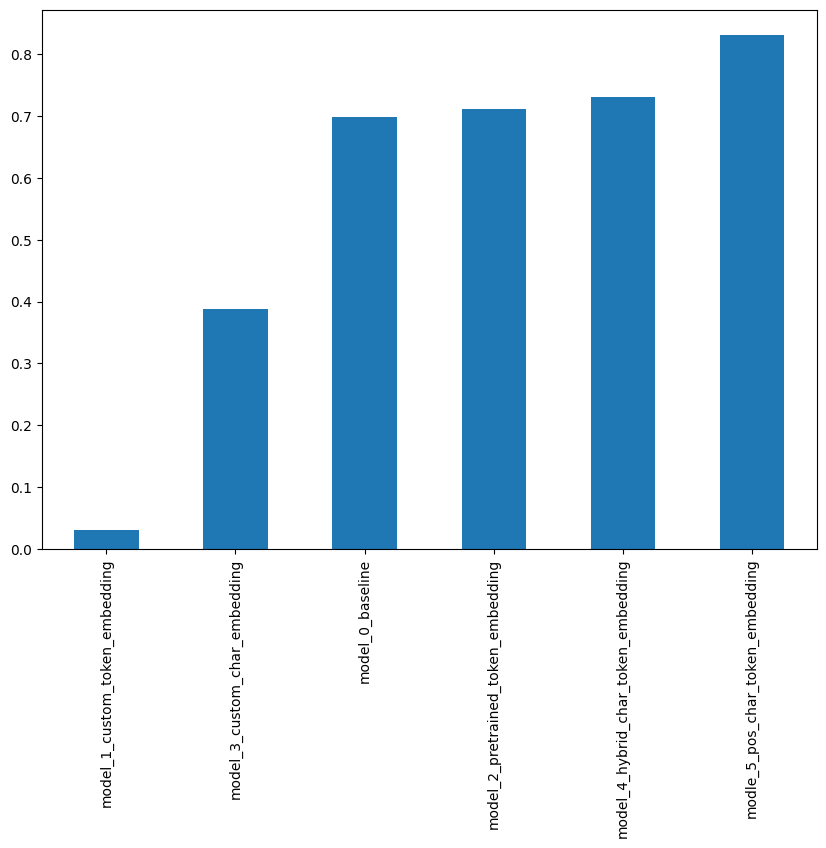

In [ ]:
all_model_results.sort_values("f1",ascending = True)["f1"].plot(kind= "bar", figsize = (10,7))